In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import scipy.io as sio
import dnatools
from plot_tools import simpleaxis, plot_splicing_histogram
import re
fsize=14
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=14


/net/gs/vol3/software/modules-sw-python/2.7.3/pandas/0.14.0/Linux/RHEL6/x86_64/lib/python2.7/site-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


### Make directory to save results:

In [2]:
resultsdir = '../results/N3_A5SS_Splicing_Frame_Analysis/'
if not os.path.exists(resultsdir):
    os.makedirs(resultsdir)
figdir = '../figures/N3_A5SS_Splicing_Frame_Analysis/'
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
#Choose if you want to actually save the plots:
SAVEFIGS = True

### Load the data

In [3]:
data = sio.loadmat('../data/Reads.mat')

# A5SS
A5SS_data = data['A5SS']
A5SS_reads = np.array(A5SS_data.sum(1)).flatten()
A5SS_data = np.array(A5SS_data.todense())
# Get minigenes with reads
A5SS_nn = find(A5SS_data.sum(axis=1))
A5SS_reads = A5SS_reads[A5SS_nn]
A5SS_data = A5SS_data[A5SS_nn]
A5SS_data = A5SS_data/A5SS_data.sum(axis=1)[:,newaxis]
A5SS_seqs = pd.read_csv('../data/A5SS_Seqs.csv',index_col=0).Seq[A5SS_nn]

First we'll define a function to get the location of an inframe stop codon. We only want to upstream of the splice donor that was spliced:

In [4]:
def in_frame_stop(seq,sd):
    """ Return the location of first stop codon before position sd
    If there is no stop codon return -1"""
    full_seq = seq
    stop_codon = -1
    for i in range(2,sd,3):
        if(full_seq[i:i+3] in ['TAA','TAG','TGA']):
            stop_codon=i
            break
    return stop_codon

For each minigene, we will calculate sd_main as the position of the splice donor with the most spliced reads. Then for each minigene, we will get the first in-frame stop codon (if there is one) for this isoform:

In [5]:
stop_codon_series = []
sd_main = A5SS_data.argmax(axis=1)
for i in range(len(A5SS_seqs)):
    stop_codon_series.append(in_frame_stop(A5SS_seqs.iloc[i],sd_main[i]))
    if (i%10000)==0:
        print i,
stop_codon_series = pd.Series(stop_codon_series)

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000


In [6]:
stop_codon_series[stop_codon_series==-1]=nan

Let's make a data frame. Each row will contain one minigene. Then we will have columns for the number of reads/minigene, the position of the first stop codon, and the position of the majority (it's really plurality, but I'll continue to refer to it as majority, because I think it's easier to understand) splice donor:

In [7]:
df = pd.DataFrame({'Reads':A5SS_reads,
                   'Stop_Codon_Pos':stop_codon_series,
                   'SD_Main':sd_main})
df['Stop_Codon_SD_Dist'] = df.SD_Main.values-df.Stop_Codon_Pos.values

We'll start first by analyzing the minigenes with no in-frame stop for the majority isoform. We will restrict the analysis to SD positions with at least 10 minigenes using it as the majority splice site. We will plot each splicing frame with a different color and plot the median reads per minigene on the y axis.

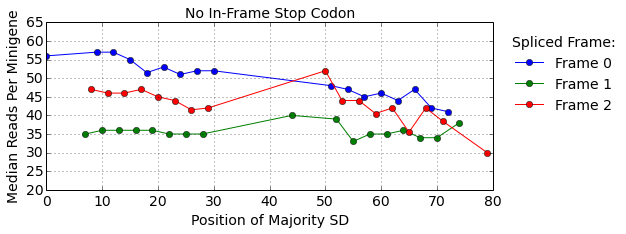

In [8]:
fig = figure(figsize=(8,3))

no_stop = df[pd.isnull(df.Stop_Codon_Pos)].groupby('SD_Main').Reads.aggregate({'Median':median,
                                                                        'Size':size})
ax = fig.add_subplot(111)
# Only plot SD positions with more than 10 minigenes using it as a majority.
no_stop[no_stop.Size>10].Median[0:-1:3].plot(marker='o',label='Frame 0')
no_stop[no_stop.Size>10].Median[1:-1:3].plot(marker='o',label='Frame 1')
no_stop[no_stop.Size>10].Median[2:-1:3].plot(marker='o',label='Frame 2')
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Position of Majority SD',fontsize=fsize)
ax.set_ylabel('Median Reads Per Minigene',fontsize=fsize)
ax.set_title('No In-Frame Stop Codon',fontsize=fsize)
ax.axis([0,80,20,65])
leg = ax.legend(bbox_to_anchor=(1.3,1),numpoints=1,title='Spliced Frame:',fontsize=fsize)
setp(leg.get_title(),fontsize=fsize)
leg.get_frame().set_alpha(0)
if SAVEFIGS:
    figname = 'Reads_by_SD_frame_nostop'
    fig.savefig(figdir+figname+'.png',bbox_inches='tight', dpi = 300)
    fig.savefig(figdir+figname+'.pdf',bbox_inches='tight', dpi = 300)
    fig.savefig(figdir+figname+'.eps',bbox_inches='tight', dpi = 300)

Now we'll do the same analysis, but instead we will restrict our analysis to minigenes that contain an in-frame stop codon between 7 to 20 nt downstream of SD1. In this plot it is clear that transcripts are being degraded by nonsense-mediated decay. I've labeled that in the figure.

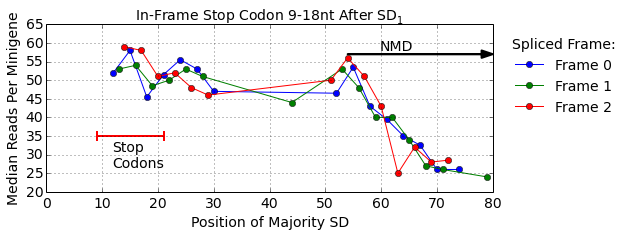

In [9]:
with_stop = df[(df.Stop_Codon_Pos>=7) & (df.Stop_Codon_Pos<20)].groupby('SD_Main').Reads.aggregate({'Median':median,
                                                                        'Size':size})
fig = figure(figsize=(8,3))
ax = fig.add_subplot(111)
with_stop[with_stop.Size>10].Median[0:-1:3].plot(marker='o',label='Frame 0')
with_stop[with_stop.Size>10].Median[1:-1:3].plot(marker='o',label='Frame 1')
with_stop[with_stop.Size>10].Median[2:-1:3].plot(marker='o',label='Frame 2')
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Position of Majority SD',fontsize=fsize)
ax.set_ylabel('Median Reads Per Minigene',fontsize=fsize)
ax.axis([0,80,20,65])
ax.arrow(54, 57, 26-2, 0, head_width=2, head_length=2,linewidth=2, fc='k', ec='k')
ax.text(60,58,'NMD',fontsize=fsize)
ax.arrow(9, 35, 12, 0, head_width=2, head_length=0,linewidth=2, fc='r', ec='r')
ax.arrow(9+12, 35, -12, 0, head_width=2, head_length=0,linewidth=2, fc='r', ec='r')
ax.text(12,34,'Stop\nCodons',fontsize=fsize,va='top')

ax.set_title('In-Frame Stop Codon 9-18nt After $SD_1$',fontsize=fsize)
leg = ax.legend(bbox_to_anchor=(1.3,1),numpoints=1,title='Spliced Frame:',fontsize=fsize)
setp(leg.get_title(),fontsize=fsize)
leg.get_frame().set_alpha(0)
if True:
    figname = 'Reads_by_SD_frame_withstop'
    fig.savefig(figdir+figname+'.png',bbox_inches='tight', dpi = 300)
    fig.savefig(figdir+figname+'.pdf',bbox_inches='tight', dpi = 300)
    fig.savefig(figdir+figname+'.eps',bbox_inches='tight', dpi = 300)